In [1]:
!pip install datasets >> log_datasets.txt
!pip install evaluate >> log_evaluate.txt
!pip install wandb >> log_wandb.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82 

In [2]:
import io
import numpy as np
import matplotlib.pyplot as plt
import evaluate
import accelerate # Import the 'accelerate' module
import itertools
from datasets import load_dataset, Image, ClassLabel
from PIL import Image as PILImage, ImageFile
import torch
from tqdm import tqdm
from transformers import ViTImageProcessor, ViTForImageClassification, pipeline, TrainingArguments, Trainer
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomApply,
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

import seaborn as sns
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

ImageFile.LOAD_TRUNCATED_IMAGES = True

import wandb
wandb.login()
wandb.init(project="train_img_vit")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: oscarparro (tfm-oscar-parro) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
raw_dataset = load_dataset("HazemAbdelkawy/emotions")
dataset = raw_dataset["train"]

dataset = dataset.rename_column("answer", "label")
dataset = dataset.remove_columns(["question"])

# Aplicar el mapeo para cambiar "anger" a "angry"
def update_label(example):
    if example["label"].lower() == "anger":
        example["label"] = "angry"
    return example

dataset = dataset.map(update_label)
dataset = dataset.filter(lambda x: x["label"] != "content")

df = dataset.to_pandas()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train-00000-of-00001.parquet:   0%|          | 0.00/371M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9400 [00:00<?, ? examples/s]

Map:   0%|          | 0/9400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9400 [00:00<?, ? examples/s]

Tamaño de la imagen: (640, 640)


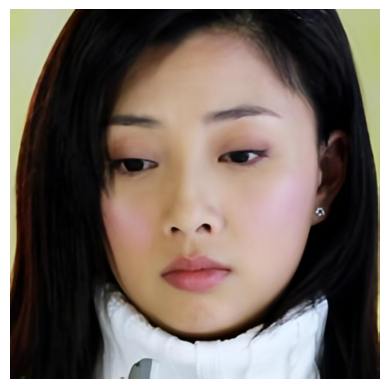

In [4]:
img_bytes = df.loc[0, "image"]["bytes"]
img = PILImage.open(io.BytesIO(img_bytes))

print("Tamaño de la imagen:", img.size)

plt.imshow(img)
plt.axis("off")
plt.show()

label
surprise    1238
neutral     1225
sad         1184
fear        1181
angry       1175
disgust     1165
happy       1088
Name: count, dtype: int64


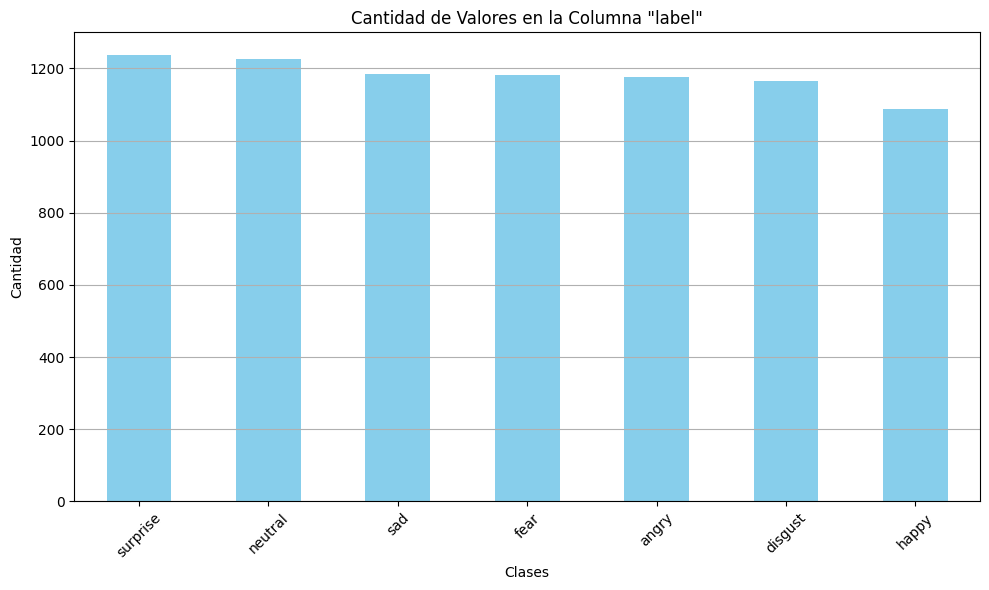

In [5]:
label_counts = df['label'].value_counts()

print(label_counts)

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Valores en la Columna "label"')
plt.xlabel('Clases')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

plt.show()

In [6]:
labels_list = ['sad' , 'disgust' , 'angry' , 'neutral' , 'fear' , 'surprise' , 'happy']

In [7]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = (i)
    id2label[i] = label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'sad', 1: 'disgust', 2: 'angry', 3: 'neutral', 4: 'fear', 5: 'surprise', 6: 'happy'} 

Mapping of Labels to IDs: {'sad': 0, 'disgust': 1, 'angry': 2, 'neutral': 3, 'fear': 4, 'surprise': 5, 'happy': 6}


In [8]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=0.3, shuffle=True, stratify_by_column="label", seed=33)

train_data = dataset['train']

test_data = dataset['test']

Map:   0%|          | 0/8256 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/8256 [00:00<?, ? examples/s]

In [9]:
model_str = 'dima806/facial_emotions_image_detection'
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Tamaño de entrada del modelo:", size)

preprocessor_config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

Tamaño de entrada del modelo: 224


In [10]:
normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose([
    Resize((size, size)),                         # Redimensiona las imágenes al tamaño requerido.
    RandomApply([RandomRotation(45)], p=0.8),       # Con un 80% de probabilidad, rota la imagen aleatoriamente hasta 45°.
    RandomApply([RandomAdjustSharpness(2)], p=0.3), # Con un 30% de probabilidad, ajusta la nitidez.
    RandomHorizontalFlip(0.5),                      # Aplica flip horizontal con 50% de probabilidad.
    ToTensor(),                                   # Convierte la imagen a tensor.
    normalize                                     # Normaliza la imagen.
])

_test_transforms = Compose([
    Resize((size, size)),  # Redimensiona las imágenes al tamaño requerido.
    ToTensor(),            # Convierte la imagen a tensor.
    normalize              # Normaliza las imágenes.
])

def train_transforms(examples):
    examples['pixel_values'] = [ _train_transforms(image.convert("RGB")) for image in examples['image'] ]
    return examples

def test_transforms(examples):
    examples['pixel_values'] = [ _test_transforms(image.convert("RGB")) for image in examples['image'] ]
    return examples


In [11]:
train_data.set_transform(train_transforms)
test_data.set_transform(test_transforms)

In [12]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

In [13]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

model.config.id2label = id2label
model.config.label2id = label2id

print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

85.804039


In [14]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions

    label_ids = eval_pred.label_ids

    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    return {
        "accuracy": acc_score
    }

In [18]:
metric_name = "accuracy"
model_name = "emotion_detection_vit"

num_train_epochs = 3

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    eval_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=4,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="wandb",
)

In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

<ipython-input-19-9c13e1b762e1>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.evaluate()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


{'eval_loss': 1.8367362022399902,
 'eval_model_preparation_time': 0.0032,
 'eval_accuracy': 0.40613645538958415,
 'eval_runtime': 45.2667,
 'eval_samples_per_second': 54.72,
 'eval_steps_per_second': 13.697}

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,No log,1.107456,0.003200,0.588615
2,No log,0.885024,0.003200,0.673799
3,No log,0.804454,0.003200,0.706904


TrainOutput(global_step=273, training_loss=0.8785110305953812, metrics={'train_runtime': 866.5642, 'train_samples_per_second': 20.007, 'train_steps_per_second': 0.315, 'total_flos': 1.343538829817985e+18, 'train_loss': 0.8785110305953812, 'epoch': 3.0})

In [22]:
trainer.evaluate()

{'eval_loss': 0.8044543266296387,
 'eval_model_preparation_time': 0.0032,
 'eval_accuracy': 0.7069035123132822,
 'eval_runtime': 44.1433,
 'eval_samples_per_second': 56.113,
 'eval_steps_per_second': 14.045,
 'epoch': 3.0}

In [23]:
outputs = trainer.predict(test_data)

print(outputs.metrics)

{'test_loss': 0.8044543266296387, 'test_model_preparation_time': 0.0032, 'test_accuracy': 0.7069035123132822, 'test_runtime': 43.1319, 'test_samples_per_second': 57.428, 'test_steps_per_second': 14.375}


Accuracy: 0.7069
F1 Score: 0.7071


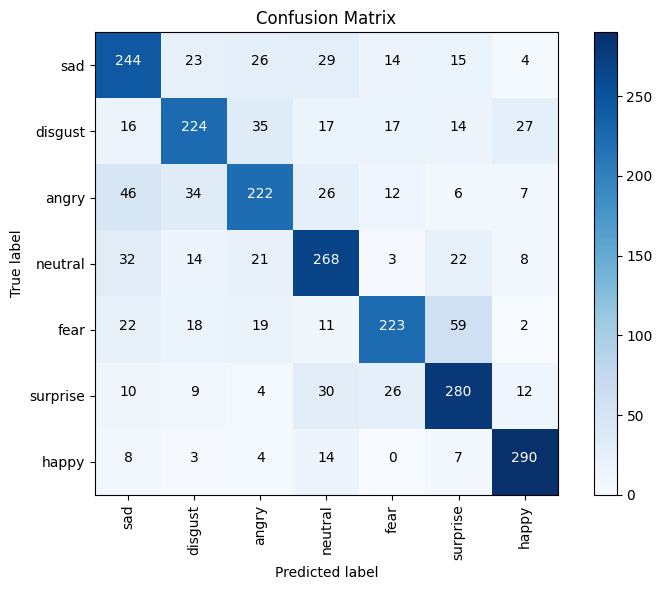


Classification report:

              precision    recall  f1-score   support

         sad     0.6455    0.6873    0.6658       355
     disgust     0.6892    0.6400    0.6637       350
       angry     0.6707    0.6289    0.6491       353
     neutral     0.6785    0.7283    0.7025       368
        fear     0.7559    0.6299    0.6872       354
    surprise     0.6948    0.7547    0.7235       371
       happy     0.8286    0.8896    0.8580       326

    accuracy                         0.7069      2477
   macro avg     0.7090    0.7084    0.7071      2477
weighted avg     0.7074    0.7069    0.7056      2477



In [24]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [25]:
trainer.save_model()

In [26]:
# Import the necessary module to interact with the Hugging Face Hub.
from huggingface_hub import notebook_login

# Perform a login to the Hugging Face Hub.
notebook_login()

In [27]:
# Import the HfApi class from the huggingface_hub library.
from huggingface_hub import HfApi

# Create an instance of the HfApi class.
api = HfApi()

# Define the repository ID by combining the username "dima806" with the model name.
repo_id = f"oscarparro/{model_name}"

try:
    # Attempt to create a new repository on the Hugging Face Model Hub using the specified repo_id.
    api.create_repo(repo_id)

    # If the repository creation is successful, print a message indicating that the repository was created.
    print(f"Repo {repo_id} created")
except:
    # If an exception is raised, print a message indicating that the repository already exists.
    print(f"Repo {repo_id} already exists")

Repo oscarparro/emotion_detection_vit already exists


In [30]:
# Uploading a folder to the Hugging Face Model Hub
api.upload_folder(
    folder_path=model_name,  # The path to the folder to be uploaded
    path_in_repo=".",  # The path where the folder will be stored in the repository
    repo_id=repo_id,  # The ID of the repository where the folder will be uploaded
    repo_type="model",  # The type of the repository (in this case, a model repository)
    revision="main" # Revision name
)

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/687M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

Upload 7 LFS files:   0%|          | 0/7 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/oscarparro/emotion_detection_vit/commit/5ac754d50bf197368e6448a979198e419bb049f8', commit_message='Upload folder using huggingface_hub', commit_description='', oid='5ac754d50bf197368e6448a979198e419bb049f8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/oscarparro/emotion_detection_vit', endpoint='https://huggingface.co', repo_type='model', repo_id='oscarparro/emotion_detection_vit'), pr_revision=None, pr_num=None)